<a href="https://colab.research.google.com/github/JanSchering/Thesis/blob/main/ABC_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title install dependencies
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# @title imports
from typing import Callable, List
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Approximate Bayesian Computation

**Given:**

- Set of observations $x \in \mathcal{X}$, generated by a Data generating Process
- The process can be described via a parametric likelihood with a probability density function (PDF) $f(x|\theta)$, $\theta \in \mathcal{R}^d$
- A prior probability distribution over $\theta$: $\pi(\theta)$

**Goal:**

Describe/Approximate the posterior distribution:

$$
\pi(\theta|x) = \frac{f(x|\theta)\pi(\theta)}{\int_{\theta \in \mathcal{R}^d} f(x|\theta)\pi(\theta)d\theta} \tag{1}
$$

⟹ If the likelihood function is not known or intractable, we cannot sample from (1) efficiently or at all. Instead, we want to draw samples from a sufficiently good approximation of (1). We can obtain these samples via *Approximate Bayesian Computation (ABC)*.

**General Approach:**

1. Define Pseudo-Posterior
2. Draw a candidate parameter vector $\theta^*$
3. generate a dataset $x^* \sim f(x|\theta^*)$
4. Accept candidate if $x^*$ is "close" enough to $x$ 
    - "Close" is defined as the distance $\rho(x^*, x)$ being smaller than a tolerance threshold $𝜀$

## Approximate Bayesian computation via rejection sampling (ABC-REJ)

1. Generate $\theta^* \sim \pi(\theta)$
2. Generate $x^* \sim f(x|\theta^*)$
3. Accept $\theta^*$ if $\rho(S(x^*), S(x)) <= \epsilon$, S(.) being the summary statistics of the dataset.
4. If rejected, return to 1.

⟶ Each accepted vector $\theta^*$ is an independent sample drawn from $f(\theta|\rho(S(x), S(x_0)) \leq \epsilon)$. If the statistics $S$ are near-sufficient and $\epsilon$ sufficiently small, $f(\theta|\rho(S(x), S(x_0)) \leq \epsilon)$ becomes a reasonable approximation of the posterior.

### Example

Taken from [this paper](https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104). Let the desired posterior be defined by the likelihood function:

$$
f(\theta|x_0) = \frac{1}{2} \phi(0,\frac{1}{100}) + \frac{1}{2}\phi(0,1)
$$

where $\phi(\mu,\sigma^2)$ is the density function of a normal distribution $N(\mu,\sigma^2)$. We define the prior $\pi(\theta)=U(-10,10)$. Further, let $\epsilon=0.025$ and the distance function be defined as:

$$
\rho(x_{sim}, x_{obs}) = 
\begin{cases}
  |\bar{x}| \text{with probability} \frac{1}{2}, \\
  |x_1| \text{with probability} \frac{1}{2} 
\end{cases}
$$

$x^*$ is generated by a normal distribution parameterized by the candidate $\theta^*$:

$$
x^* \sim \mathcal{N}(\theta^*,1)
$$


In [ ]:
# @title Helper functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(np.sqrt(2*np.pi)*np.sqrt(sigma_sq)))*np.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

# note: The distance function would usually depend on the original dataset as well.
# Not necessary in this case as the mean of the original dataset should simply be 0.
# Distance function as defined in the paper.
def calc_distance(x_sim:np.ndarray) -> float:
  if random.random() > 0.5:
    return np.abs(np.mean(x_sim))
  else:
    return np.abs(x_sim[0])

# The paper defines a uniform prior 
def sample_from_prior(num_samples:int) -> np.ndarray:
  return np.random.uniform(-10, 10, num_samples)

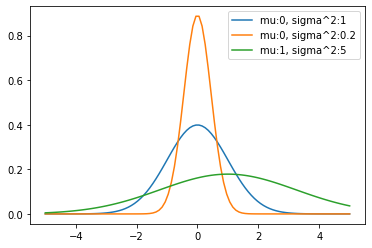

In [ ]:
# @title Tests { vertical-output: true}
pdf_1 = gaussian_pdf(0,1)
pdf_2 = gaussian_pdf(0,0.2)
pdf_3 = gaussian_pdf(1,5)

xs = np.linspace(-5,5,100)

plt.plot(xs, [pdf_1(x) for x in xs], label="mu:0, sigma^2:1")
plt.plot(xs, [pdf_2(x) for x in xs], label="mu:0, sigma^2:0.2")
plt.plot(xs, [pdf_3(x) for x in xs], label="mu:1, sigma^2:5")
plt.legend()

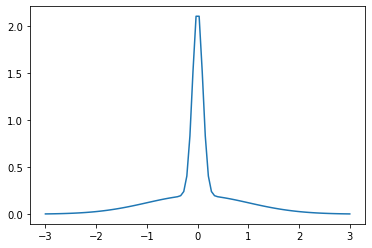

In [ ]:
# @title Define and visualize the posterior { vertical-output: true}
pdf_1 = gaussian_pdf(0,1/100)
pdf_2 = gaussian_pdf(0,1)

def posterior(theta:float) -> float:
  return (1/2)*pdf_1(theta) + (1/2)*pdf_2(theta)

thetas = np.linspace(-3,3,100)

plt.plot(thetas, [posterior(theta) for theta in thetas])

In [ ]:
# @title define ABC-REJ 
epsilon = 0.025

def ABC_REJ() -> float:
  num_steps = 1
  theta = None
  while True:
    theta = sample_from_prior(1)
    x_sim = np.random.normal(theta, 1, 100)
    distance = calc_distance(x_sim)
    if distance <= epsilon:
      break
    else:
      num_steps += 1
  return theta, num_steps

100%|██████████| 1000/1000 [00:17<00:00, 58.71it/s]


average # steps for acceptance: 396.688


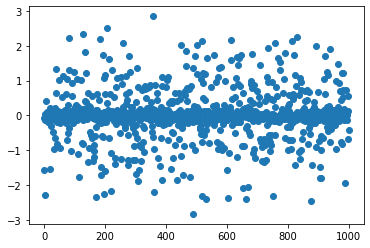

In [ ]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}

samples = []
required_steps = []

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1000)):
  sample, num_steps = ABC_REJ()
  samples.append(sample)
  required_steps.append(num_steps)

print(f"average # steps for acceptance: {np.mean(required_steps)}")

plt.scatter(np.arange(len(samples)), samples)


## Approximate Bayesian computation via Markov-Chain Monte-Carlo (ABC-MCMC)

1. Initialize $\theta_1, i=1$
2. Generate $\theta^* \sim q(\theta|\theta_i)$, from an arbitrary proposal density $q$
3. Generate $x^* \sim f(x|\theta^*)$
4. Set $\theta_{i+1}=\theta^*$ with the following probability:

$$
\alpha = \min \begin{cases} 1, \frac{\pi(\theta^*)q(\theta_i|\theta^*)}{\pi(\theta_i)q(\theta^*|\theta_i)} \textbf{1}(\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon) \end{cases}
$$

Set $\theta_{i+1}=\theta_{i}$ otherwise.

Here, $\textbf{1}(A)$ is true if the statement $A$ evaluates to $True$, 0 otherwise.

### Example

We use the same toy example as for ABC-REJ, taken from [this paper](https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104). Let the desired posterior be defined by the likelihood function:

$$
f(\theta|x_0) = \frac{1}{2} \phi(0,\frac{1}{100}) + \frac{1}{2}\phi(0,1)
$$

where $\phi(\mu,\sigma^2)$ is the density function of a normal distribution $N(\mu,\sigma^2)$. 

****

For ABC-MCMC, we define $\theta_0=0$, $N=10,000$ iterations and $\epsilon=0.025$. The proposal density function is defined as a random walk $q(\theta|\theta_t) \sim \mathcal{N}(\theta_t, 0.15^2)$. The simulated dataset $x^*$ consists of 100 samples drawn from a normal distribution, $x^* \sim \mathcal{N}(\theta,1)$.

The distance function is given by:

$$
\rho(x_{sim}, x_{obs}) =
\begin{cases}
  |\bar{x}| \text{with probability} \frac{1}{2}, \\
  |x_1| \text{with probability} \frac{1}{2} 
\end{cases} 
$$

In [ ]:
# @title Helper Functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(np.sqrt(2*np.pi)*np.sqrt(sigma_sq)))*np.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

def q(theta:float) -> float:
  return np.random.normal(theta, 0.15**2)

def calc_distance(x_sim:np.ndarray) -> float:
  if random.random() > 0.5:
    return np.abs(np.mean(x_sim))
  else:
    return np.abs(x_sim[0])

def calc_alpha(q:Callable, theta_star:float, theta:float, epsilon:float, x_sim:np.ndarray) -> float:
  dist = calc_distance(x_sim)
  if dist <= epsilon:
    return min([1,q(theta)/q(theta_star)])
  else:
    return 0


In [ ]:
# @title Define ABC-MCMC
def ABC_MCMC(N:int, epsilon:float, theta:float, q:Callable) -> List[float]:
  thetas = [theta]
  for i in tqdm(range(N)):
    theta_star = q(theta)
    x_sim = np.random.normal(theta_star, 1, 100)
    alpha = calc_alpha(q, theta_star, theta, epsilon, x_sim)
    if random.random() <= alpha:
      theta = theta_star
    thetas.append(theta)
  return thetas

100%|██████████| 10000/10000 [00:00<00:00, 36538.90it/s]


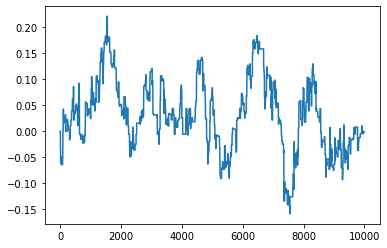

In [ ]:
# @title Run ABC-MCMC for the example { vertical-output: true}
N = 10_000
epsilon = 0.025
theta_init = 0

thetas = ABC_MCMC(N, epsilon, theta_init, q)

plt.plot(np.arange(len(thetas)), thetas)

## Approximate Bayesian computation via Sequential Monte-Carlo with Particle Rejection Control (ABC-PRC)

**Goal:**

Draw $N$ samples (particles) from the posterior distribution $f(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon)$.

**Given:**

- Summary statistics $S(.)$
- Threshold $\epsilon$
- Distance Function $\rho$ 

**Approach:**

1. Define an initial population $\theta^{(1)}, \dots, \theta^{(N)} \sim \mu_1$, with $\mu_1$ being a known distribution we can sample from
2. Define $f_T(\theta) = f(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon)$

→ Standard Importance Sampling: Weigh all drawn particles by their importance $W^{(i)}_T = f_T(\theta^{(i)}_1)/\mu_1(\theta^{(i)}_1)$.

****

**Problem 1:** Can fail or become inefficient if there is a mismatch between sampling distribution $\mu_1$ and target distribution $f_T$ 

⟶ Solution (Sequential Sampling): Define a sequence of intermediary distributions $f_1, \dots, f_{T-1}$, gradually moving from $\mu_1$ towards $f_T$. Then iteratively move and reweight the particles in accordance to their adherence to each consecutive distribution $f_t,$ for $t=1,\dots,T$.

In the case of ABC, the sequence of distributions can be defined as:

$$
f_t(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon_t) = \frac{\pi(\theta)}{B_t} \sum_{b=1}^{B_t} \textbf{1}(\rho(S(x_{(b)}), S(x_{obs})) \leq \epsilon_t)
$$

with:

- $x_{(1)},\dots, x_{(B_t)}$ being $B_T$ datasets generated with a fixed parameter vector $\theta$, $x_{(b)} \sim f(x|\theta)$
- $\{\epsilon_t\}$ being a strictly decreasing sequence of thresholds

****

**Problem 2:** With this method, the particle weights are directly proportional to the likelihood of the particles. There is a high probability that this likelihood equates to 0. A zero-likelihood means zero weight, which makes the particle useless as it is out of consideration.

⟶ Solution (Particle Rejection Control): Using PRC, we can resample from the previous distribution and move the sampled particles, in order to get a replacement for those particles with zero-weight. We do this replacement step until we have a population of $N$ particles with non-zero weight.

****

**ABC-PRC Algorithm:**

1. Define
  - $\epsilon_1, \dots, \epsilon_T$ 
  - sampling distribution $\mu_1$
  - population indicator $t=1$
2. Set particle indicator $i=1$, then
  1. IF
  - $t == 1$: sample $\theta^{**} \sim \mu_1(\theta)$ independently 
  - $t > 1$: sample $\theta^{*}$ from the prev. population, weighted by their importance $W^{(i)}_{t-1}$, then move the particle to $\theta^{**} \sim K_t(\theta|\theta^*)$ according to a Markov transition kernel $K_t$
  2. Sample $x^{**} \sim f(x|\theta^{**})$
  3. IF $\rho(S(x^{**}), S(x_{obs})) \geq \epsilon_t$, go back to 2.1
  4. Set 
$$
\theta^{(i)}_t = \theta^{**}, W^{(i)}_t = 
\begin{cases}
\pi(\theta^{(i)}_t)/\mu_1(\theta^{(i)}_t) \text{if t==1}, \\
\frac{\pi(\theta^{(i)}_t)L_{t-1}(\theta^*|\theta^{(i)}_t)}{\pi(\theta^*)K_t(\theta^{(i)}_t|\theta^*)} \text{if t>1}
\end{cases}
$$
with $\pi(\theta)$ being the prior distribution and $L_{t-1}$ a backward transition kernel
  5. IF $i < N$, increment $i = i + 1$ then return to 2.1
3. Normalize the weights, such that $\sum_{i=1}^N W^{(i)}_t = 1$
4. Calculate $ESS = [\sum_{i=1}^N (W^{(i)}_t)^2]^{-1}$. IF $ESS < E$, resample the particles $\{\theta^{(i)}_t\}$ with current weights $\{W^{(i)}_t\}$ to get a new population of particles $\{\theta^{(i)}_t\}$. Set the weights of the new population to $\{W^{(i)}_t = 1/N \}$.
5. IF $t < T$, increment $t=t+1$ and return to 2.

NOTE: If $T=1$ and $\mu_1(\theta)=\pi(\theta)$, ABC-PRC is equivalent to ABC-REJ.

****

**Implementation Notes from the paper:**

- In the examples, $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$ as a gaussian kernel with common variance
- From $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$, $\mu_1(\theta)=\pi(\theta)$, $\pi(\theta) \propto 1$ over the parameters space $\Theta$, follows that all weights are equal during sampling and can be ignored. This also means that for this special case steps 3. and 4. can be ignored

### Example 

We consider the same example from [this paper](https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104). Let the desired posterior be defined by the likelihood function:

$$
f(\theta|x_0) = \frac{1}{2} \phi(0,\frac{1}{100}) + \frac{1}{2}\phi(0,1)
$$

where $\phi(\mu,\sigma^2)$ is the density function of a normal distribution $N(\mu,\sigma^2)$. 

****

For ABC-PRC, we use:

- A population of $N=1000$ particles
- A sequence of three distributions $f_1, f_2, f_3$ defined through:
$$
f_t(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon_t) = \frac{\pi(\theta)}{B_t} \sum_{b=1}^{B_t} \textbf{1}(\rho(S(x_{(b)}), S(x_{obs})) \leq \epsilon_t)
$$
- $\epsilon_1=2, \epsilon_2=0.5, \epsilon_3=0.025$
- $\pi(\theta) \sim U(-10,10)$
- $\mu_1(\theta)=\pi(\theta)$
- $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$, gaussian random walks

In [59]:
# @title Helper Functions
Sampler = Callable[[int], np.ndarray]

def mu_1(num_samples:int) -> float:
  return np.random.uniform(-10, 10, num_samples)

def calc_distance(x_sim:np.ndarray) -> float:
  if random.random() > 0.5:
    return np.abs(np.mean(x_sim))
  else:
    return np.abs(x_sim[0])

In [60]:
# @title Define ABC-PRC
def ABC_PRC(N:int, epsilons, mu_1:Sampler):
  thetas = mu_1(1000)
  theta_hist = [np.copy(thetas)]
  for t, epsilon in enumerate(epsilons):
    for i, theta in enumerate(thetas):
      close_enough = False
      theta_star = theta_ss = x_ss = None
      while not close_enough:
        # Sample from previous population
        theta_star = np.random.choice(thetas, size=1)
        # Move the particle with a gaussian markov kernel
        theta_ss = np.random.normal(theta_star, 1)
        # sample x** using theta**
        x_ss = np.random.normal(theta_ss, 1, 100)
        # check the distance
        close_enough = calc_distance(x_ss) <= epsilon
      thetas[i] = theta_ss.copy()
    theta_hist.append(np.copy(thetas))
  return thetas, theta_hist

In [61]:
# @title Run ABC-PRC for the example
N = 1000
epsilons = [2, 0.5, 0.025]

thetas, theta_hist = ABC_PRC(N, epsilons, mu_1)

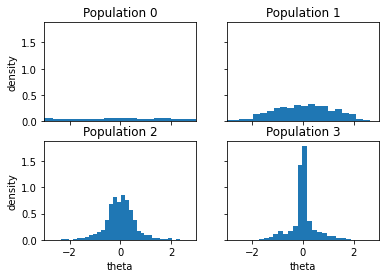

In [62]:
# @title visualize results { vertical-output: true}
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

axs[0,0].hist(theta_hist[0], density=True, bins=30)
axs[0,0].set(ylabel='density', title="Population 0")
axs[0,1].hist(theta_hist[1], density=True, bins=30)
axs[0,1].set(title="Population 1")
axs[1,0].hist(theta_hist[2], density=True, bins=30)
axs[1,0].set(xlabel='theta', ylabel='density', title="Population 2")
axs[1,1].hist(theta_hist[3], density=True, bins=30)
axs[1,1].set(xlabel='theta', title="Population 3")

plt.xlim(-3,3)
plt.show()